   ## Housing prices, data analysis and predictions
___

    1 Determining what is the price changes per county from 2010 to 2016


## Census API


#### Code and Description
____


* B01003_001E = Population 
* B01002_001E = Median Age 
* B19013_001E = Household Income
* B19301_001E = Per Capita Income
* B25077_001E = Median Value Housing Units
* B17001_002E = Poverty Count 
____


<br />
<br />

## FIPS (Federal Information Processing Standards)

#### State FIPS code
* 13 Georgia

#### County FIPS code
___

* 13121 - Fulton County
* 13135 - Gwinnett County
* 13089 - DeKalb County
* 13067 - Cobb County
* 13063 - Clayton County
* 13057 - Cherokee County
* 13151 - Henry County
* 13117 - Forsyth County
* 13097 - Douglas County
___


In [2]:
## Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import requests
from census import Census
import gmaps
from scipy.stats import sem
from scipy.stats import linregress
from IPython.display import display, HTML, clear_output
from sklearn.externals import joblib
import time


# Census & gmaps API Keys
from security.census_key import (api_key, gkey)

# Internal functionality
from functions import print_message,calculate_percentage,get_column_des,get_merged_data,get_fields,get_filters,print_message,print_plot,print_bars, get_zillow_column_des, get_std_error, print_trendline

zillow_csv = './data/County_MedianListingPrice_AllHomes.csv'

# Years to be retrieved from census API
years = np.arange(2010, 2017, 1)

### Getting Census data from API

In [3]:
# Run Census Search to retrieve data on all Atlanta metro counties
array_census_data = []

print_message("Starting retrieving data from Census API")

# Iterate throught the years array and call the Census API:
for year in years:
    census_API = Census(api_key, year = year)

    array_census_data.append(pd.DataFrame(census_API.acs5.get(get_fields(), get_filters())).rename(columns = get_column_des(year)))
    
    print(f"Processing data from census on year:{year}")


print_message("Retrieving data from Census API done")


-----------------------------------------
Starting retrieving data from Census API
-----------------------------------------
Processing data from census on year:2010
Processing data from census on year:2011
Processing data from census on year:2012
Processing data from census on year:2013
Processing data from census on year:2014
Processing data from census on year:2015
Processing data from census on year:2016
-----------------------------------------
Retrieving data from Census API done
-----------------------------------------


### Clean and formatting  Census data

In [11]:
# Merge all the datasets previously retrieved.
census_data = get_merged_data(array_census_data, ['Name', 'State', 'MunicipalCodeFIPS'])

# Delete columns that we no longer use.
census_data.drop(columns="State", inplace=True)

# Insert index to the new and merged DataFrame.
census_data.set_index(["MunicipalCodeFIPS", "Name"], inplace=True)

# Show dataframe.
census_data.head(2)


,,Median Age 2010,Population 2010,Poverty Count 2010,Household Income 2010,Per Capita Income 2010,Median Value Housing Units 2010,Median Age 2011,Population 2011,Poverty Count 2011,Household Income 2011,...,Poverty Count 2015,Household Income 2015,Per Capita Income 2015,Median Value Housing Units 2015,Median Age 2016,Population 2016,Poverty Count 2016,Household Income 2016,Per Capita Income 2016,Median Value Housing Units 2016
MunicipalCodeFIPS,Name,,,,,,,,,,,,,,,,,,,,,
013,"Barrow County, Georgia",32.9,66359.0,8295.0,48958.0,20882.0,138900.0,33.1,68061,8912,50604,...,10902.0,52012.0,21411.0,119700.0,35.0,73340.0,10548.0,53133.0,21978.0,123200.0
015,"Bartow County, Georgia",36.1,97423.0,13472.0,49216.0,22241.0,146800.0,36.2,98905,15076,49060,...,15819.0,48893.0,22592.0,123800.0,37.4,101942.0,14899.0,50565.0,23376.0,128200.0


### Zillow Data Munging from .CSV  

In [10]:
# Get Zillow CSV historical data.
# Source: https://www.zillow.com/research/data/
zillow_data = pd.read_csv(zillow_csv)

# Defining FIPS for State and Counties.
georgia_fips = 13
county_fips = ['121','135','089','067','063','057','151','117','097','077','045','113','015','297','013','227','085','199','171']

# Filtering CSV by State and Countues.
metro_atlanta_data = zillow_data[(zillow_data["StateCodeFIPS"] == georgia_fips) & (zillow_data["MunicipalCodeFIPS"].isin(county_fips))]

# Delete columns no longer needed.
metro_atlanta_data = metro_atlanta_data.drop(columns=["State", "Metro", "StateCodeFIPS", "SizeRank", "RegionName"])

# Define new index for DataFrame.
metro_atlanta_data.set_index(["MunicipalCodeFIPS"], inplace=True)

# Transpose DataFrame in order to filter year-month with ease.
metro_atlanta_data = metro_atlanta_data.T

# Remove index.
metro_atlanta_data.reset_index(inplace=True)

# Replace text for year-month to year.
metro_atlanta_data["year"] = metro_atlanta_data["index"].apply(lambda x: x[:(len(x) - x.find("-")) + 1])

# Delete columns no longer needed.
metro_atlanta_data = metro_atlanta_data.drop(columns=["index"])

# Group data by year and get the average amount.
metro_atlanta_data = metro_atlanta_data.groupby("year").mean()

# Transpose again the DataFrame.
metro_atlanta_data = metro_atlanta_data.T

# Decorate the DataFrame with columns description.
metro_atlanta_data.rename(columns=get_zillow_column_des(), inplace=True)

# Show DataFrame.
metro_atlanta_data.head(2)


year,Zillow Median Value Housing 2010,Zillow Median Value Housing 2011,Zillow Median Value Housing 2012,Zillow Median Value Housing 2013,Zillow Median Value Housing 2014,Zillow Median Value Housing 2015,Zillow Median Value Housing 2016,Zillow Median Value Housing 2017,Zillow Median Value Housing 2018
MunicipalCodeFIPS,,,,,,,,,
121,214815.000000,184231.25,197416.666667,233341.666667,251515.500000,263650.416667,303332.500000,352743.125,382600.0000
135,167389.041667,141300.00,141926.666667,181081.666667,200884.583333,218675.083333,237650.083333,255407.375,279210.3125


### Merging Census and Zillow DataFrames

In [9]:
census_data_reset = census_data.reset_index()

census_data_reset["MunicipalCodeFIPS"] = census_data_reset["MunicipalCodeFIPS"].astype("l")

metro_atlanta_data_reset = metro_atlanta_data.reset_index()

zillow_census_data = pd.merge(census_data_reset, metro_atlanta_data_reset, how="outer", left_on="MunicipalCodeFIPS", right_on="MunicipalCodeFIPS")

zillow_census_data.set_index(["MunicipalCodeFIPS", "Name"], inplace=True)

zillow_census_data.to_csv("./data/zillow_census_data.csv")

zillow_census_data.head(2)


,,Median Age 2010,Population 2010,Poverty Count 2010,Household Income 2010,Per Capita Income 2010,Median Value Housing Units 2010,Median Age 2011,Population 2011,Poverty Count 2011,Household Income 2011,...,Median Value Housing Units 2016,Zillow Median Value Housing 2010,Zillow Median Value Housing 2011,Zillow Median Value Housing 2012,Zillow Median Value Housing 2013,Zillow Median Value Housing 2014,Zillow Median Value Housing 2015,Zillow Median Value Housing 2016,Zillow Median Value Housing 2017,Zillow Median Value Housing 2018
MunicipalCodeFIPS,Name,,,,,,,,,,,,,,,,,,,,,
13,"Barrow County, Georgia",32.9,66359.0,8295.0,48958.0,20882.0,138900.0,33.1,68061,8912,50604,...,123200.0,130150.000,101891.666667,96191.666667,121120.833333,143908.875,156055.25,169008.333333,184349.583333,201605.625
15,"Bartow County, Georgia",36.1,97423.0,13472.0,49216.0,22241.0,146800.0,36.2,98905,15076,49060,...,128200.0,135982.375,121733.958333,111964.583333,127450.000000,144440.000,158712.50,180064.666667,196071.875000,205881.250


### Looking for Correlations

In [31]:
correlation = zillow_census_data[["Median Age 2016",
"Population 2016",
"Poverty Count 2016",
"Household Income 2016",
"Per Capita Income 2016",
"Zillow Median Value Housing 2016"]].corr()
correlation["Zillow Median Value Housing 2016"].sort_values(ascending=False)

Zillow Median Value Housing 2016    1.000000
Per Capita Income 2016              0.914057
Household Income 2016               0.867888
Median Age 2016                     0.408847
Population 2016                     0.235961
Poverty Count 2016                  0.090142
Name: Zillow Median Value Housing 2016, dtype: float64

### Ploting Median Value Housing

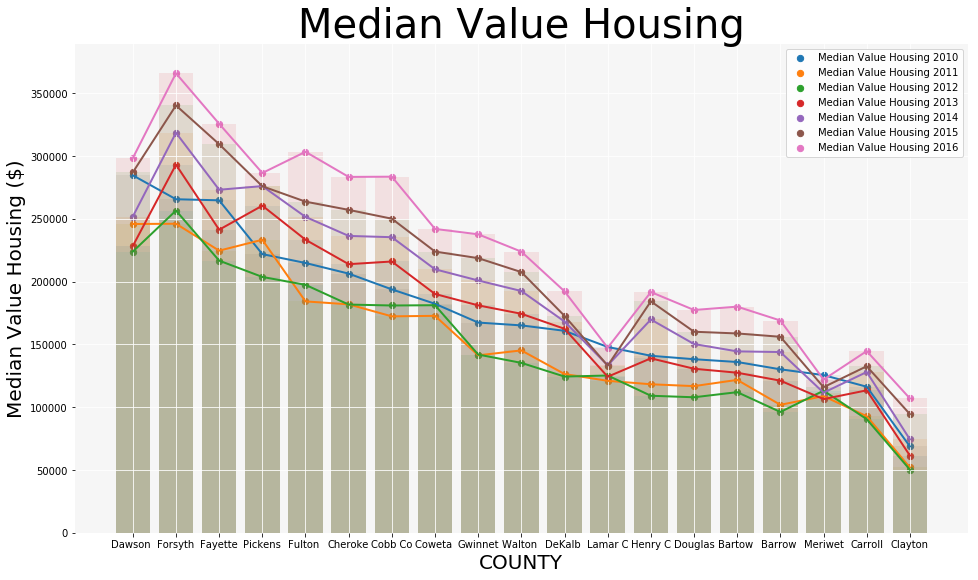

In [13]:
housing_data_by_year = zillow_census_data[["Zillow Median Value Housing 2010",
"Zillow Median Value Housing 2011",
"Zillow Median Value Housing 2012",
"Zillow Median Value Housing 2013",
"Zillow Median Value Housing 2014",
"Zillow Median Value Housing 2015",
"Zillow Median Value Housing 2016"]].reset_index()

housing_data_by_year.drop(columns="MunicipalCodeFIPS", inplace=True)

housing_data_by_year.set_index("Name", inplace=True)

housing_data_by_year.sort_values(by=['Zillow Median Value Housing 2010',
                                    'Zillow Median Value Housing 2011',
                                    'Zillow Median Value Housing 2012',
                                    'Zillow Median Value Housing 2013',
                                    'Zillow Median Value Housing 2014',
                                    'Zillow Median Value Housing 2015',
                                    'Zillow Median Value Housing 2016',], ascending=False, inplace=True)

housing_data_by_year_x = [(x[:(len(x) - x.find(" County,")) - 9]) for x in housing_data_by_year.index.values]

fig, ax = plt.subplots()
ax.plot(housing_data_by_year_x, housing_data_by_year, linewidth = 2)
ax.scatter(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2010"], s = 40, label="Median Value Housing 2010")
ax.scatter(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2011"], s = 40, label="Median Value Housing 2011")
ax.scatter(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2012"], s = 40, label="Median Value Housing 2012")
ax.scatter(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2013"], s = 40, label="Median Value Housing 2013")
ax.scatter(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2014"], s = 40, label="Median Value Housing 2014")
ax.scatter(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2015"], s = 40, label="Median Value Housing 2015")
ax.scatter(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2016"], s = 40, label="Median Value Housing 2016")

ax.bar(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2010"], alpha=0.1, label=None)
ax.bar(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2011"], alpha=0.1, label=None)
ax.bar(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2012"], alpha=0.1, label=None)
ax.bar(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2013"], alpha=0.1, label=None)
ax.bar(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2014"], alpha=0.1, label=None)
ax.bar(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2015"], alpha=0.1, label=None)
ax.bar(housing_data_by_year_x, housing_data_by_year["Zillow Median Value Housing 2016"], alpha=0.1, label=None)

ax.grid()
ax.legend(loc="best")

ax.set_title("Median Value Housing", fontdict={"fontsize": "40"})
ax.set_xlabel("COUNTY", fontdict={"fontsize": "20"})
ax.set_ylabel("Median Value Housing ($)", fontdict={"fontsize": "20"})

ax.set_facecolor('#f6f6f6')
ax.grid(color="w")
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.set_size_inches(16, 9)

fig.savefig('./images/housing_data_by_year.png')


### Plotting grouped mean of (Median Value Housing) from 2010 to 2016

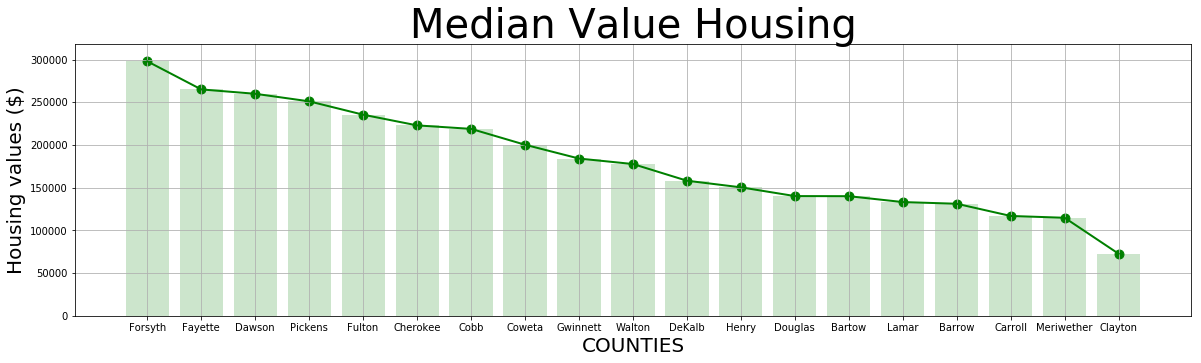

In [14]:
display(HTML(f'<marquee>All these results are based on the calculated MEDIAN from 2010 to 2016 from Value Housing</marquee>'))

fig = plt.figure()

ax = fig.subplots()

zillow_value_housing = zillow_census_data[['Zillow Median Value Housing 2010',
             'Zillow Median Value Housing 2011',
             'Zillow Median Value Housing 2012',
             'Zillow Median Value Housing 2013',
             'Zillow Median Value Housing 2014',
             'Zillow Median Value Housing 2015',
             'Zillow Median Value Housing 2016'
            ]].astype('float').T.mean()

zillow_value_housing = zillow_value_housing.reset_index()

zillow_value_housing = zillow_value_housing.drop(columns=["MunicipalCodeFIPS"])

zillow_value_housing = zillow_value_housing.set_index("Name")

zillow_value_housing = zillow_value_housing[0].sort_values(ascending=False)

zillow_value_housing_x = [(x[:(len(x) - (len(x) - x.find(" County,")))]) for x in zillow_value_housing.index.values]

ax.plot(zillow_value_housing_x, zillow_value_housing, linewidth = 2, color="g")
ax.scatter(zillow_value_housing_x, zillow_value_housing, label=None, s = 80, color="g")
ax.bar(zillow_value_housing_x, zillow_value_housing, color="g", alpha=0.2)

ax.set_title("Median Value Housing", fontdict= {'fontsize': "40"})
ax.set_xlabel("COUNTIES", fontdict={'fontsize': "20"})
ax.set_ylabel("Housing values ($)", fontdict={'fontsize': "20"})

ax.grid()

fig.set_size_inches(20, 5)

fig.savefig('./images/zillow_value_housing.png')


### Plotting Grouped Mean of (Median Income Per Capita) from 2010 to 2016

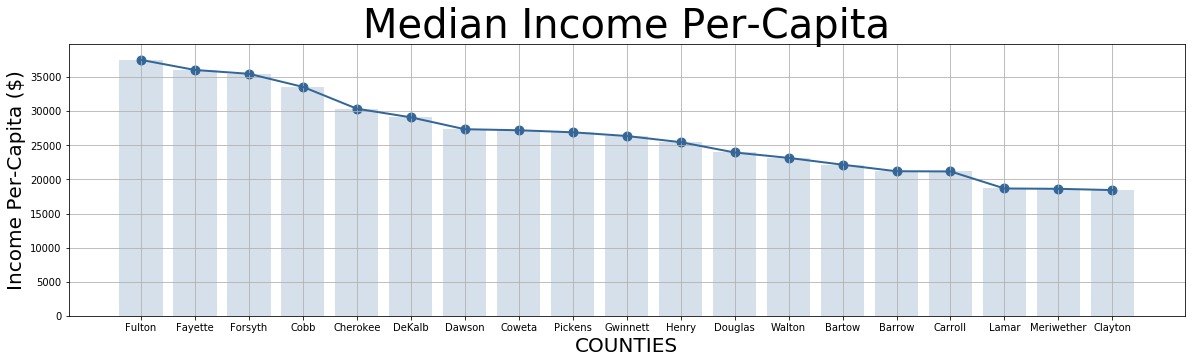

In [16]:
display(HTML(f'<marquee>All these results are based on the calculated MEDIAN from 2010 to 2016 from INCOME PER CAPITA</marquee>'))

fig, ax = plt.subplots()

median_income_capita = zillow_census_data[['Per Capita Income 2010',
             'Per Capita Income 2011',
             'Per Capita Income 2012',
             'Per Capita Income 2013',
             'Per Capita Income 2014',
             'Per Capita Income 2015',
             'Per Capita Income 2016'
            ]].astype('float').T.mean()

median_income_capita = median_income_capita.reset_index()

median_income_capita = median_income_capita.drop(columns=["MunicipalCodeFIPS"])

median_income_capita = median_income_capita.set_index("Name")

median_income_capita = median_income_capita[0].sort_values(ascending=False)

median_income_capita_x = [(x[:(len(x) - (len(x) - x.find(" County,")))]) for x in median_income_capita.index.values]

ax.plot(median_income_capita_x, median_income_capita, linewidth = 2, color="#336699")
ax.scatter(median_income_capita_x, median_income_capita, label=None, s = 80, color="#336699")
ax.bar(median_income_capita_x, median_income_capita, color="#336699", alpha=0.2)

ax.set_title("Median Income Per-Capita", fontdict= {'fontsize': "40"})
ax.set_xlabel("COUNTIES", fontdict={'fontsize': "20"})
ax.set_ylabel("Income Per-Capita ($)", fontdict={'fontsize': "20"})

ax.grid()

fig.set_size_inches(20, 5)

fig.savefig('./images/median_income_capita.png')


### Plotting Grouped Mean of (Household Income) from 2010 to 2016

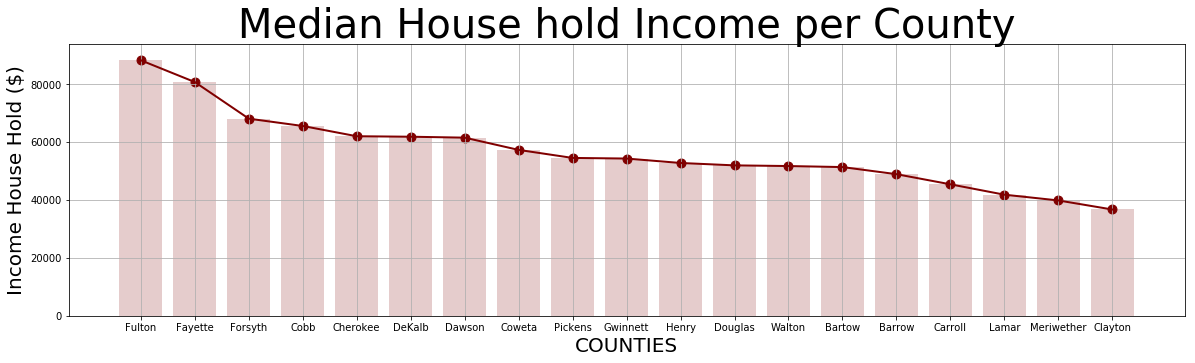

In [17]:
display(HTML(f'<marquee>All these results are based on the calculated MEDIAN from 2010 to 2016</marquee>'))

fig, ax = plt.subplots()

median_income_house_hold = census_data[['Household Income 2010',
             'Household Income 2011',
             'Household Income 2012',
             'Household Income 2013',
             'Household Income 2014',
             'Household Income 2015',
             'Household Income 2016'
            ]].astype('float').T.mean()

median_income_house_hold = median_income_house_hold.reset_index()

median_income_house_hold = median_income_house_hold.drop(columns=["MunicipalCodeFIPS"])

median_income_house_hold = median_income_house_hold.set_index("Name")

median_income_house_hold = median_income_house_hold[0].sort_values(ascending=False)

median_income_house_hold_x = [(x[:(len(x) - (len(x) - x.find(" County,")))]) for x in median_income_capita.index.values]

ax.plot(median_income_house_hold_x, median_income_house_hold, linewidth = 2, color="#800000")
ax.scatter(median_income_house_hold_x, median_income_house_hold, label=None, s = 80, color="#800000")
ax.bar(median_income_house_hold_x, median_income_house_hold, color="#800000", alpha=0.2)

ax.set_title("Median House hold Income per County", fontdict= {'fontsize': "40"})
ax.set_xlabel("COUNTIES", fontdict={'fontsize': "20"})
ax.set_ylabel("Income House Hold ($)", fontdict={'fontsize': "20"})

ax.grid()

fig.set_size_inches(20, 5)

fig.savefig('./images/median_income_house_hold.png')


### Plotting Median Value Housing vs Per Capita Income

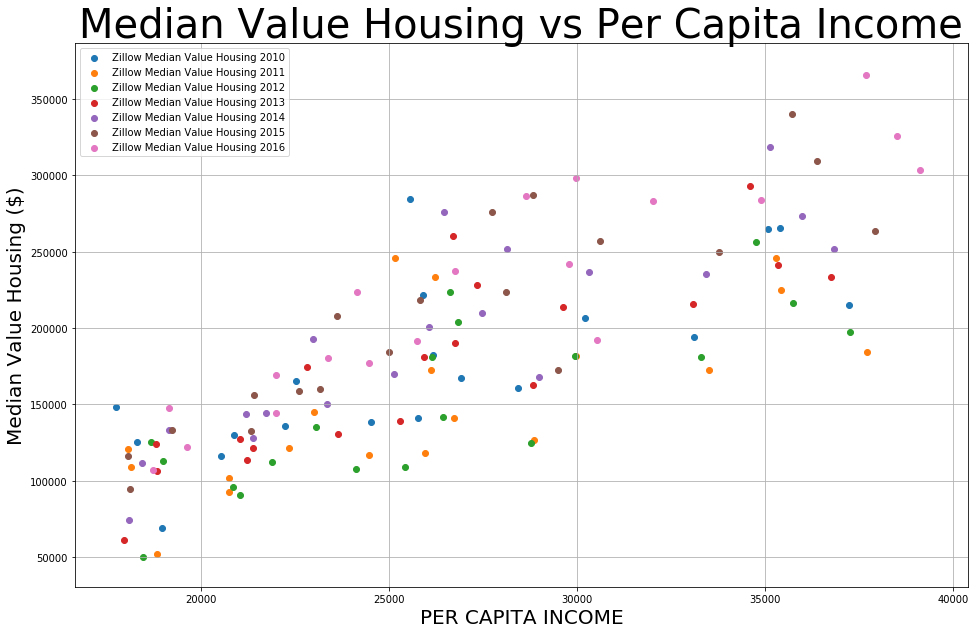

In [24]:
income_capita = zillow_census_data[['Per Capita Income 2010',
             'Per Capita Income 2011',
             'Per Capita Income 2012',
             'Per Capita Income 2013',
             'Per Capita Income 2014',
             'Per Capita Income 2015',
             'Per Capita Income 2016'
            ]].astype('float')

fig, ax = plt.subplots()

ax.scatter(income_capita["Per Capita Income 2010"], zillow_census_data["Zillow Median Value Housing 2010"])
ax.scatter(income_capita["Per Capita Income 2011"], zillow_census_data["Zillow Median Value Housing 2011"])
ax.scatter(income_capita["Per Capita Income 2012"], zillow_census_data["Zillow Median Value Housing 2012"])
ax.scatter(income_capita["Per Capita Income 2013"], zillow_census_data["Zillow Median Value Housing 2013"])
ax.scatter(income_capita["Per Capita Income 2014"], zillow_census_data["Zillow Median Value Housing 2014"])
ax.scatter(income_capita["Per Capita Income 2015"], zillow_census_data["Zillow Median Value Housing 2015"])
ax.scatter(income_capita["Per Capita Income 2016"], zillow_census_data["Zillow Median Value Housing 2016"])

ax.set_title("Median Value Housing vs Per Capita Income", fontdict={'fontsize': "40"})
ax.set_xlabel("PER CAPITA INCOME", fontdict={'fontsize': "20"})
ax.set_ylabel("Median Value Housing ($)", fontdict={'fontsize': "20"})
plt.legend()
plt.grid()

fig.set_size_inches(16, 10)

fig.savefig('./images/income_capita.png')


### Linear Regression of (Median Value Housing vs Per Capita Income) from 2010 to 2016

In [25]:
zillow_census_data_mean = zillow_census_data[["Zillow Median Value Housing 2010",
                                             "Zillow Median Value Housing 2011",
                                             "Zillow Median Value Housing 2012",
                                             "Zillow Median Value Housing 2013",
                                             "Zillow Median Value Housing 2014",
                                             "Zillow Median Value Housing 2015",
                                             "Zillow Median Value Housing 2016"]].astype('float').T.mean()

income_capita_mean = income_capita[["Per Capita Income 2010",
                                             "Per Capita Income 2011",
                                             "Per Capita Income 2012",
                                             "Per Capita Income 2013",
                                             "Per Capita Income 2014",
                                             "Per Capita Income 2015",
                                             "Per Capita Income 2016"]].astype('float').T.mean()

# Calculating Regression Line.
value = linregress(income_capita_mean, zillow_census_data_mean)

# Using HTML embeded to print results and Formula.
display(HTML('<h2>Analysis after line regression</h2>'))
display(HTML(f'<li>p-value: {value.pvalue}</li>'))
display(HTML(f'<li>slope: {value.slope}</li>'))
display(HTML(f'<li>intercept on y: {value.intercept}</li>'))
display(HTML(f'<h4>Regression line formula:</h4>'))
display(HTML(f'<code>Median Value Housing = {value.intercept} + ({value.slope} * X)</code>'))

# Make the formula to be plotted.
regression =  (value.slope * income_capita_mean) + value.intercept


### Plotting grouped mean of (Median Value Housing vs Per Capita Income) from 2010 to 2016

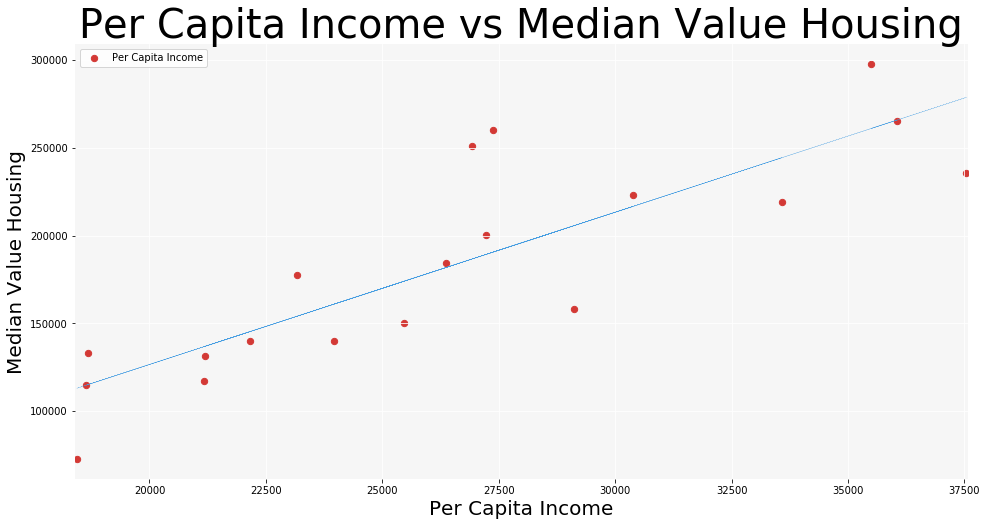

In [26]:
display(HTML(f'<marquee>All these results are based on the average data from 2010 until 2016 for Percapita Income vs Median Value Housing</marquee>'))

# Start plotting the results.
fig, ax = plt.subplots()

ax.scatter(income_capita_mean, zillow_census_data_mean, label="Per Capita Income", color="#D33935", s=40)
ax.plot(income_capita_mean, regression, "--", color="#459DE1", linewidth=0.3)

ax.set_title("Per Capita Income vs Median Value Housing", fontdict={"fontsize": "40"})
ax.set_xlabel("Per Capita Income", fontdict={'fontsize': "20"})
ax.set_ylabel("Median Value Housing", fontdict={'fontsize': "20"})
ax.set_xlim(18400, 37570)

plt.legend(loc="upper left")
plt.grid()

ax.set_facecolor('#f6f6f6')
ax.grid(color="w")
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.set_size_inches(16, 8)

fig.savefig('./images/income_capita_mean.png')


## Conclusions
___

### Creating a Linear Regression Machine Learning with Scikit-Learn


In [27]:
housing_data_housing_value = zillow_census_data[["Zillow Median Value Housing 2010",
"Zillow Median Value Housing 2011",
"Zillow Median Value Housing 2012",
"Zillow Median Value Housing 2013",
"Zillow Median Value Housing 2014",
"Zillow Median Value Housing 2015",
"Zillow Median Value Housing 2016"]].reset_index()

housing_data_housing_value.drop(columns="Name", inplace=True)

housing_data_housing_value.set_index("MunicipalCodeFIPS", inplace=True)

housing_data_housing_value = housing_data_housing_value.astype('float').T.mean()

housing_data_housing_value = housing_data_housing_value.reset_index()

housing_data_housing_value = housing_data_housing_value.rename(columns={0:"Median Value Housing"})

housing_data_percapita = income_capita[["Per Capita Income 2010",
 "Per Capita Income 2011",
 "Per Capita Income 2012",
 "Per Capita Income 2013",
 "Per Capita Income 2014",
 "Per Capita Income 2015",
 "Per Capita Income 2016"]].reset_index()

housing_data_percapita.drop(columns="Name", inplace=True)

housing_data_percapita.set_index("MunicipalCodeFIPS", inplace=True)

housing_data_percapita = housing_data_percapita.astype('float').T.mean()

housing_data_percapita = housing_data_percapita.reset_index()

housing_data_percapita = housing_data_percapita.rename(columns={0:"Per Capita Income"})

housing_data_ = pd.merge(housing_data_percapita, housing_data_housing_value, right_on="MunicipalCodeFIPS", left_on="MunicipalCodeFIPS") 

X = housing_data_.iloc[:, :-1]
y = housing_data_.iloc[:, 2]

housing_data_.head()


,MunicipalCodeFIPS,Per Capita Income,Median Value Housing
0,13,21202.857143,131189.517857
1,15,22164.857143,140049.726190
2,45,21177.428571,116897.327381
3,57,30376.428571,222949.970238
4,63,18442.428571,72624.184524


### Create and save Linear Regression model

In [32]:
from sklearn.linear_model import LinearRegression
capita_model = LinearRegression()
capita_model.fit(X, y)

### Saving model into file storage.
start = time.time()
joblib.dump(capita_model, "./back-end/capita_model.model")
end = time.time() - start

"Time in miliseconds to save model in disk: {:2}".format(end)


'Time in miliseconds to save model in disk: 0.0035216808319091797'

### Create a HTML page to interact with the model through and API

In [33]:
with open('./model_test.html') as form:
    display(HTML(form.read()))
